In [1]:
import numpy as np
from eDisk_source_dict import source_dict
import astropy.units as u
import astropy.constants as ac
import matplotlib.pyplot as plt
from qdisk.classes import FitsImage
from qdisk.plot import Map
%matplotlib widget
%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "out",
    "ytick.direction": "out"})

au_to_cm = ac.au.to(u.cm).value

source = "L1489IRS"
distance = source_dict[source]["distance"]
center_coord = source_dict[source]["radec"]
PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]
cont_nu0 = source_dict[source]["cont_nu0"]

gridfilename = "./model/amr_grid.inp"
modefilename = "./model/dust_temperature.dat"

In [2]:
################################### GET THE MODEL DATA #############################################
#### read grid ###
# get the number of grids for each axis
nr, ntheta, nphi = np.loadtxt(gridfilename, skiprows=5, max_rows=1, unpack=True, dtype=int)

# grid edge values
grids = np.loadtxt(gridfilename, skiprows=6, unpack=True)
r_edge, theta_edge, phi_edge = np.split(grids, [nr+1, nr+ntheta+2])

# grid center
r_center     = np.average([r_edge[1:], r_edge[:-1]], axis=0) # in cm
theta_center = np.average([theta_edge[1:], theta_edge[:-1]], axis=0) # in rad
phi_center   = np.average([phi_edge[1:], phi_edge[:-1]], axis=0) # in rad

# meshgrid
r, theta, phi = np.meshgrid(r_center, theta_center, phi_center, indexing="ij")
r_cylind = r * np.sin(theta)
z_cylind = r * np.cos(theta)

### read model temperature ###
model_temperature = np.loadtxt(modefilename, skiprows=3, unpack=True)
model_temperature = model_temperature.reshape((nphi, ntheta, nr)).T

### r-z plane ###
# average along phi axis
rztemp = np.mean(model_temperature, axis=2)
r2d = r_cylind[:,:,0]/au_to_cm
z2d = z_cylind[:,:,0]/au_to_cm

### get midplane temperature ###
r_model = np.nanmax(r2d, axis=1) # where the theta (from z to r) is max
ridx = np.argmax(r2d, axis=1)
T_model = rztemp[:, ridx].mean(axis=1)

### save ###
filename = "./data/Sai20_model_Tdust_profile.npz"
np.savez(filename, r=r_model, T=T_model)

In [4]:
######################## GET OBSERVED VALUES #########################
# continuum Tb
rmax = 8
imagename = "/works/yamato/eDisk/L1489IRS/ALMA_pipeline_calibrated_data/L1489IRS_SBLB_continuum_robust_1.0.image.tt0.fits"
contimage = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
contimage.shift_phasecenter_toward(center_coord)
contimage.convert_unit(unit="K", RJ_approx=False, nu=cont_nu0)
r_cont, Tb_cont, dTb_cont = contimage.radial_profile(wedge_angle=45, rmax=rmax, PA=PA, incl=incl)
# r_cont *= distance
filename = "./data/continuum_robust1.0_radial_profile_Tb.npz"
np.savez(filename, r=r_cont, Tb=Tb_cont, dTb=dTb_cont)

Calculating radial profile...
Done.


In [12]:
# C18O peak Tb
rmax = 8
dr = 0.025
rbins = np.arange(dr*0.5, rmax, dr)
imagename = "./VADP/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image_Fnu.fits"
peakmap = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
peakmap.shift_phasecenter_toward(center_coord)
# peakmap.convert_unit(unit="K", RJ_approx=False)
peakmap.estimate_rms(rmin=rmax)
r_C18O, Tb_C18O, dTb_C18O = peakmap.radial_profile(wedge_angle=45, rbins=rbins,  PA=PA, incl=incl, )
# r_C18O *= distance
filename = "./data/C18O_peak_radial_profile_Jy.npz"
np.savez(filename, r=r_C18O, Tb=Tb_C18O, dTb=dTb_C18O)

# 13CO peak Tb
imagename = "./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.image_Fnu.fits"
peakmap = FitsImage(imagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
peakmap.shift_phasecenter_toward(center_coord)
# peakmap.convert_unit(unit="K", RJ_approx=False)
peakmap.estimate_rms(rmin=rmax)
r_13CO, Tb_13CO, dTb_13CO = peakmap.radial_profile(wedge_angle=45, rbins=rbins, PA=PA, incl=incl)
# r_13CO *= distance
filename = "./data/13CO_peak_radial_profile_Jy.npz"
np.savez(filename, r=r_13CO, Tb=Tb_13CO, dTb=dTb_13CO)

Calculating radial profile...
Done.
Calculating radial profile...
Done.


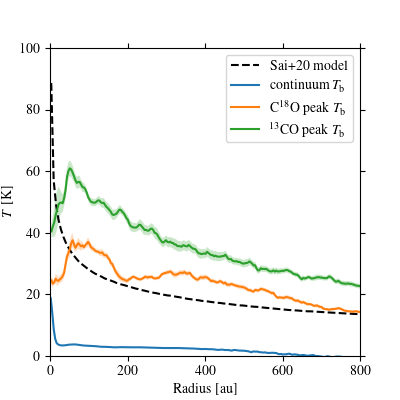

In [26]:
######################### PLOTTING ###################################
fig, ax = plt.subplots(figsize=(4,4))

# model
ax.plot(r_model, T_model, label="Sai+20 model", color="black", ls="dashed")

# cont Tb
# Tb_cont *= 10
# dTb_cont *= 10
ax.plot(r_cont, Tb_cont, label="continuum $T_\mathrm{b}$", color="tab:blue")
ax.fill_between(r_cont, Tb_cont-dTb_cont, Tb_cont+dTb_cont, alpha=0.25, color="tab:blue", edgecolor=None)

# C18O Tb
ax.plot(r_C18O, Tb_C18O, label="C$^{18}$O peak $T_\mathrm{b}$", color="tab:orange")
ax.fill_between(r_C18O, Tb_C18O-dTb_C18O, Tb_C18O+dTb_C18O, alpha=0.25, color="tab:orange", edgecolor=None)

# 13CO Tb
ax.plot(r_13CO, Tb_13CO, label="$^{13}$CO peak $T_\mathrm{b}$", color="tab:green")
ax.fill_between(r_13CO, Tb_13CO-dTb_13CO, Tb_13CO+dTb_13CO, alpha=0.25, color="tab:green", edgecolor=None)

### appearance
ax.set(xlim=(0, 800), ylim=(0,100), xlabel="Radius [au]", ylabel="$T$ [K]")
ax.legend()

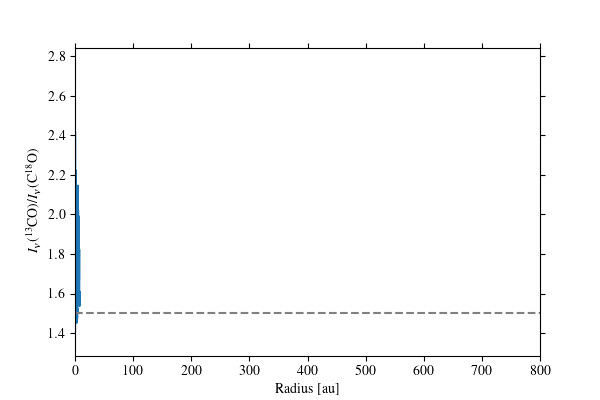

In [13]:
from uncertainties import unumpy

Tb_tco = unumpy.uarray(Tb_13CO, dTb_13CO)
Tb_ceo = unumpy.uarray(Tb_C18O, dTb_C18O)
ratio = unumpy.nominal_values(Tb_tco/Tb_ceo)
ratio_e = unumpy.std_devs(Tb_tco/Tb_ceo)
filename = "./data/13CO_C18O_peak_ratio_radial_profile.npz"
np.savez(filename, r=r_13CO, ratio=ratio, dratio=ratio_e)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(r_13CO, ratio, color="tab:blue")
ax.fill_between(r_13CO, ratio-ratio_e, ratio+ratio_e, alpha=0.25, color="tab:blue", edgecolor=None)
ax.set(xlim=(0, 800), xlabel="Radius [au]", ylabel="$I_{\\nu}$($^{13}$CO)/$I_{\\nu}$(C$^{18}$O)")
ax.axhline(y=1.5, ls="dashed", color="grey")
# ax.grid()

In [58]:
### 13CO velocity structure

from qdisk.product import calculate_pvdiagram

PA = source_dict[source]["PA"]
incl = source_dict[source]["incl"]

imagename = "/works/yamato/eDisk/L1489IRS/custom_images/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.pbcor.fits"
cube = FitsImage(imagename)
cube.shift_phasecenter_toward(center_coord)
cube.estimate_rms(edgenchan=2, rmax=8)
print(cube.rms)

x, v, diag = calculate_pvdiagram(imagename, center_coord=center_coord, PA=PA, rrange=(-12,12))

0.0018609492
Loading data ...
Calculating PV diagram...
Done.


[(-2.0, 2.0)]

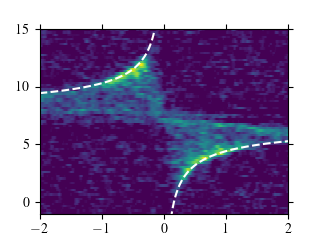

In [63]:
from qdisk.plot import PVDiagram
from qdisk.model import Keplerian_velocity

pvdiag = PVDiagram(diag, posax=x, velax=v)
pvdiag.plot_colormap(vmin=0.0)
pvdiag.add_Keplerian_curve(Mstar=1.6, distance=distance, incl=incl, vsys=7.35, ls="dashed")
pvdiag.ax.set(xlim=(-2,2))

# vkep = Keplerian_velocity(r=x*distance, Mstar=1.6, incl=incl)
# pvdiag.ax.plot(x[x>0], -vkep[x>0]+7.22, color="white")
# pvdiag.ax.plot(x[x<0], vkep[x<0]+7.22, color="white")
# pvdiag.ax.set(ylim=(-2, 18))


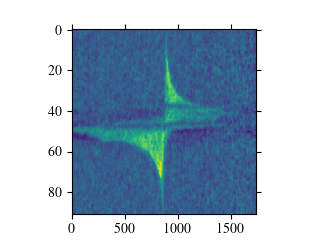

In [31]:
fig, ax = plt.subplots()
ax.imshow(diag)
ax.set_aspect(1/ax.get_data_ratio())

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/qdisk/plot.py:216: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fitsname_or_data == "self":


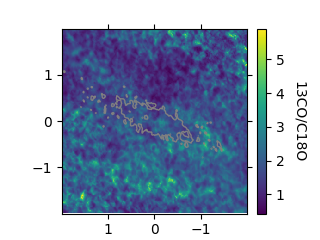

In [12]:
import analysis_utils as au
path = "./VADP/"
imagename = {
    "13CO": path + au.get_image_basename(source=source, baseline="SBLB", line="13CO", robust=1.0, dv=0.2).replace(".fits", "_Fnu.fits"),
    "C18O": path + au.get_image_basename(source=source, baseline="SBLB", line="C18O", robust=1.0, dv=0.2).replace(".fits", "_Fnu.fits"),
}
contimagename = path + au.get_image_basename(source=source, baseline="SBLB", line="continuum", robust=1.0, type="pbcor")

rmax = 2
tcoimage = FitsImage(imagename["13CO"], xlim=(-rmax, rmax), ylim=(-rmax, rmax))
tcoimage.shift_phasecenter_toward(source_dict[source]["radec"])

ceoimage = FitsImage(imagename["C18O"], xlim=(-rmax, rmax), ylim=(-rmax, rmax))
ceoimage.shift_phasecenter_toward(source_dict[source]["radec"])

ratio = tcoimage.data / ceoimage.data

ratiomap = Map(ratio, x=ceoimage.x, y=ceoimage.y, center_coord=source_dict[source]["radec"])
ratiomap.plot_colormap()
ratiomap.add_colorbar(label="13CO/C18O")
contimage = FitsImage(contimagename, xlim=(-rmax, rmax), ylim=(-rmax, rmax))
ratiomap.overlay_contour(contimage.data, x=contimage.x, y=contimage.y, levels=np.array([7])*14e-6)

2.412284001438185

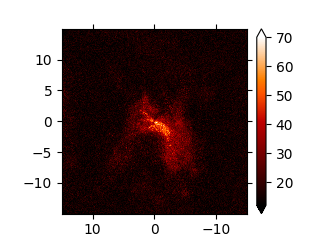

In [19]:
# plot Tb map
imagename = "./VADP/L1489IRS_SBLB_13CO_robust_1.0_dv0.2.image_Fnu.fits"
rmax = 15
fig, ax = plt.subplots()
peakmap = Map(imagename, ax=ax, xlim=(-rmax, rmax), ylim=(-rmax, rmax), center_coord=center_coord)
peakmap.convert_unit()
peakmap.estimate_rms(rmin=12)
peakmap.plot_colormap(cmap="gist_heat", vmin=5*peakmap.rms, vmax=70)
peakmap.add_colorbar()
peakmap.rms

In [ ]:
### surface fit
from disksurf import observation

cube = observation("/works/yamato/eDisk/L1489IRS/custom_images/L1489IRS_SBLB_C18O_robust_1.0_dv0.2.image.fits", FOV=10)
cube.plot_channels()

In [8]:
chans = [(24, 36), (55, 69)]
# chans = (57, 69)
from eDisk_source_dict import source_dict
source = "L1489IRS"
vlsr = 7.22e3
PA = source_dict[source]["PA"] +180
incl = source_dict[source]["incl"]

surface = cube.get_emission_surface(PA=PA, inc=incl, vlsr=vlsr, chans=chans)

Rotating data cube...
Detecting peaks...
Done!


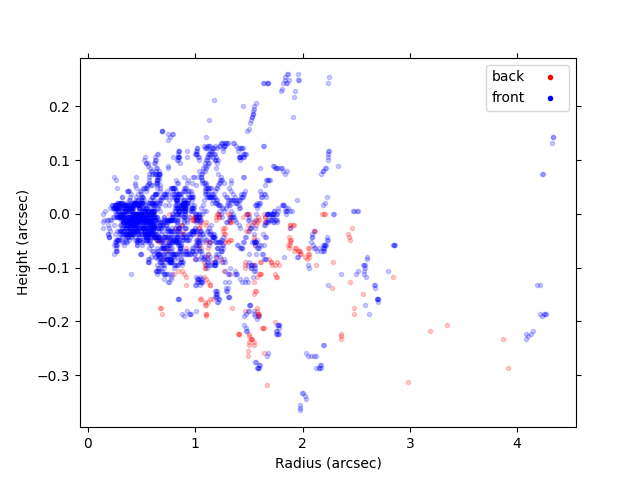

In [9]:
surface.plot_surface()

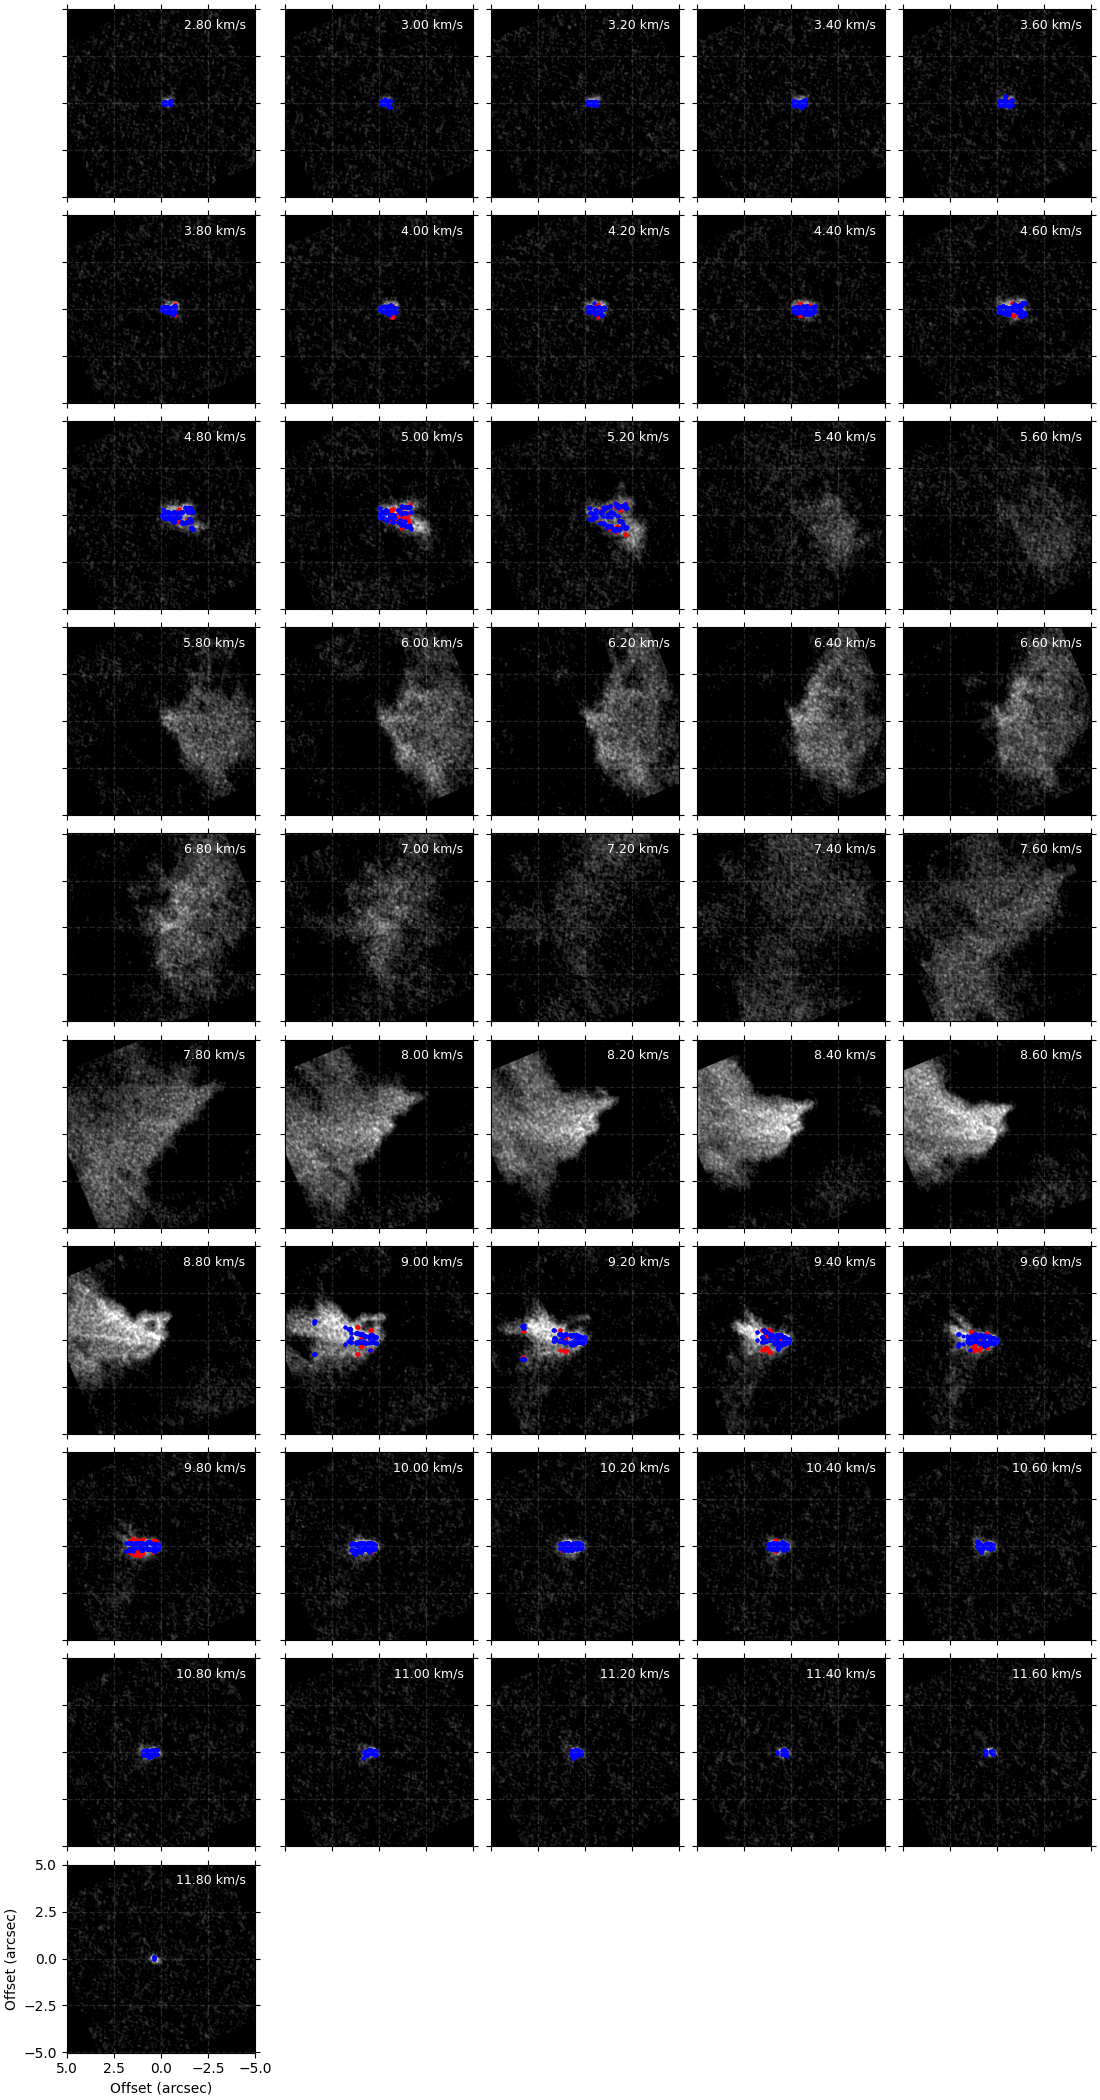

In [10]:
cube.plot_peaks(surface=surface)

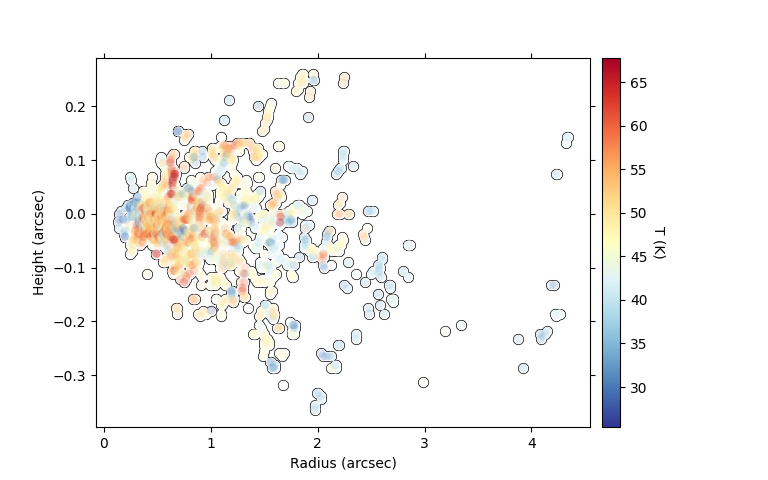

In [12]:
cube.plot_temperature(surface=surface)

0.8458970107524513